# 1. Import Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn import cluster as cl
from sklearn import model_selection as mdl
from sklearn import decomposition as dec
from sklearn import manifold as man
from sklearn import compose as com
from sklearn.base import TransformerMixin
from sklearn import linear_model as lin
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import impute as imp
from sklearn.experimental import enable_iterative_imputer
from sklearn import tree
from sklearn import ensemble as ens
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing as pre
from sklearn import metrics as met
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', 300)

sns.set_theme(style="white", palette=None)

In [2]:
# a function to check a dataframe quickly in terms of dtypes, total counts,# of unique values, # of NA values.
def df_check(df):
    print(f'shape: {df.shape}')
    l=[]
    columns=df.columns
    for col in columns:
        dtypes = df[col].dtypes
        n_count = df[col].count()
        nunique = df[col].nunique()
        sum_null = df[col].isnull().sum()
        l.append([col,dtypes,n_count,nunique,sum_null])
        
    df_check=pd.DataFrame(l,columns=['column','dtypes','count','nunique','sum_null'])
    df_check['null_ratio'] = (df_check['sum_null'] / df.shape[0]*100).round(1)

    return df_check

# 2. Load Datasets

In [3]:
## Since we have multiple csv files,firstly get their names 

all_file_names = os.listdir()
train_csv_names = []
test_csv_names = []

for f in all_file_names:
    if '.csv' in f:
        if f in ['2019_07.csv','2019_08.csv']:
            test_csv_names.append(f)
        else:
            train_csv_names.append(f)

print(f'Train CSV File Names:\n{train_csv_names}\n')
print(f'Test CSV File Names:\n{test_csv_names}\n')

Train CSV File Names:
['2018_07.csv', '2018_08.csv', '2018_09.csv', '2018_10.csv', '2018_11.csv', '2018_12.csv', '2019_01.csv', '2019_02.csv', '2019_03.csv', '2019_04.csv', '2019_05.csv', '2019_06.csv']

Test CSV File Names:
['2019_07.csv', '2019_08.csv']



In [4]:
def combine_csv(csv_files):
    all_df_data = []

    for csv_file in csv_files:
        temp_df = pd.read_csv(csv_file, index_col=None, header=0)
        print(f"{csv_file} has read\tits shape: {temp_df.shape}\tmin_date: {temp_df['FL_DATE'].min()}, max_date: {temp_df['FL_DATE'].max()}")
        all_df_data.append(temp_df)

    df = pd.concat(all_df_data, axis=0, ignore_index=True)
    return df

## 2.1 Load `Train` Data

In [5]:
df_train = combine_csv(train_csv_names)

2018_07.csv has read	its shape: (645299, 23)	min_date: 2018-07-01, max_date: 2018-07-31
2018_08.csv has read	its shape: (644673, 23)	min_date: 2018-08-01, max_date: 2018-08-31
2018_09.csv has read	its shape: (585749, 23)	min_date: 2018-09-01, max_date: 2018-09-30
2018_10.csv has read	its shape: (616101, 23)	min_date: 2018-10-01, max_date: 2018-10-31
2018_11.csv has read	its shape: (586178, 23)	min_date: 2018-11-01, max_date: 2018-11-30
2018_12.csv has read	its shape: (593842, 23)	min_date: 2018-12-01, max_date: 2018-12-31
2019_01.csv has read	its shape: (583985, 23)	min_date: 2019-01-01, max_date: 2019-01-31
2019_02.csv has read	its shape: (533175, 23)	min_date: 2019-02-01, max_date: 2019-02-28
2019_03.csv has read	its shape: (632074, 23)	min_date: 2019-03-01, max_date: 2019-03-31
2019_04.csv has read	its shape: (612023, 23)	min_date: 2019-04-01, max_date: 2019-04-30
2019_05.csv has read	its shape: (636390, 23)	min_date: 2019-05-01, max_date: 2019-05-31
2019_06.csv has read	its shape: 

### 2.1.1. Quick Check the `Train` Datasets

In [6]:
# Quick Check for the Train dataframe
df_check(df_train)

shape: (7306180, 23)


,column,dtypes,count,nunique,sum_null,null_ratio
0,FL_DATE,object,7306180,365,0,0.0
1,OP_UNIQUE_CARRIER,object,7306180,17,0,0.0
2,OP_CARRIER_FL_NUM,int64,7306180,7147,0,0.0
3,ORIGIN,object,7306180,359,0,0.0
4,DEST,object,7306180,359,0,0.0
5,CRS_DEP_TIME,int64,7306180,1362,0,0.0
6,DEP_TIME,float64,7176554,1440,129626,1.8
7,DEP_DELAY,float64,7175251,1541,130929,1.8
8,CRS_ARR_TIME,int64,7306180,1429,0,0.0
9,ARR_TIME,float64,7169046,1440,137134,1.9


In [7]:
df_train.head(3)

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 22
0,2018-07-01,YV,6007,IAH,BTR,1945,1939.0,-6.0,2049,2043.0,...,64.0,64.0,44.0,253.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-07-01,YV,6012,ATL,IAD,1951,1944.0,-7.0,2146,2125.0,...,115.0,101.0,81.0,534.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-07-01,YV,6012,IAD,ATL,1705,1705.0,0.0,1915,1901.0,...,130.0,116.0,82.0,534.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_train.tail(3)

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 22
7306177,2019-06-30,G4,358,LAX,OKC,630,624.0,-6.0,1120,1114.0,...,170.0,170.0,149.0,1187.0,NaN,NaN,NaN,NaN,NaN,NaN
7306178,2019-06-30,G4,1411,AUS,PIT,1940,1936.0,-4.0,2331,2328.0,...,171.0,172.0,153.0,1210.0,NaN,NaN,NaN,NaN,NaN,NaN
7306179,2019-06-30,G4,1376,SAV,CVG,1832,1839.0,7.0,2009,2019.0,...,97.0,100.0,70.0,515.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# drop the unnecessary and completely empty column called 'Unnamed: 22'
df_train.drop(columns=['Unnamed: 22'],inplace=True)
df_train.shape

(7306180, 22)

In [10]:
# Check is there any duplicate rows
df_train.duplicated().sum()

0

There aren't any duplicated rows.

In [11]:
#Change the FL_DATE object type to datetime64
df_train = df_train.astype({'FL_DATE' : 'datetime64[ns]'})

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306180 entries, 0 to 7306179
Data columns (total 22 columns):
 #   Column               Dtype         
---  ------               -----         
 0   FL_DATE              datetime64[ns]
 1   OP_UNIQUE_CARRIER    object        
 2   OP_CARRIER_FL_NUM    int64         
 3   ORIGIN               object        
 4   DEST                 object        
 5   CRS_DEP_TIME         int64         
 6   DEP_TIME             float64       
 7   DEP_DELAY            float64       
 8   CRS_ARR_TIME         int64         
 9   ARR_TIME             float64       
 10  ARR_DELAY            float64       
 11  CANCELLED            float64       
 12  CANCELLATION_CODE    object        
 13  CRS_ELAPSED_TIME     float64       
 14  ACTUAL_ELAPSED_TIME  float64       
 15  AIR_TIME             float64       
 16  DISTANCE             float64       
 17  CARRIER_DELAY        float64       
 18  WEATHER_DELAY        float64       
 19  NAS_DELAY            

In [13]:
# Let's Store original datasets before going further
df_train_org = df_train.copy()

## 2.2 Load `Test` Data

In [14]:
df_test = combine_csv(test_csv_names)

2019_07.csv has read	its shape: (659029, 23)	min_date: 2019-07-01, max_date: 2019-07-31
2019_08.csv has read	its shape: (658461, 23)	min_date: 2019-08-01, max_date: 2019-08-31


### 2.2.1. Quick Check the `Test` Datasets

In [15]:
# Quick Check for the test dataframe
df_check(df_test)

shape: (1317490, 23)


,column,dtypes,count,nunique,sum_null,null_ratio
0,FL_DATE,object,1317490,62,0,0.0
1,OP_UNIQUE_CARRIER,object,1317490,17,0,0.0
2,OP_CARRIER_FL_NUM,int64,1317490,6556,0,0.0
3,ORIGIN,object,1317490,356,0,0.0
4,DEST,object,1317490,356,0,0.0
5,CRS_DEP_TIME,int64,1317490,1233,0,0.0
6,DEP_TIME,float64,1294597,1439,22893,1.7
7,DEP_DELAY,float64,1294594,1277,22896,1.7
8,CRS_ARR_TIME,int64,1317490,1322,0,0.0
9,ARR_TIME,float64,1292940,1440,24550,1.9


In [16]:
df_test.head(3)

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 22
0,2019-07-01,NK,227,BOS,MCO,820,813.0,-7.0,1137,1115.0,...,197.0,182.0,144.0,1121.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-01,NK,230,FLL,ATL,2237,2235.0,-2.0,32,17.0,...,115.0,102.0,79.0,581.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-01,NK,231,ATL,FLL,600,558.0,-2.0,756,747.0,...,116.0,109.0,89.0,581.0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_test.tail(3)

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 22
1317487,2019-08-31,OO,3132,PHX,ABQ,1920,1915.0,-5.0,2138,2127.0,...,78.0,72.0,54.0,328.0,NaN,NaN,NaN,NaN,NaN,NaN
1317488,2019-08-31,OO,3133,ABQ,PHX,625,617.0,-8.0,644,637.0,...,79.0,80.0,55.0,328.0,NaN,NaN,NaN,NaN,NaN,NaN
1317489,2019-08-31,OO,3134,MKE,ORD,800,755.0,-5.0,901,850.0,...,61.0,55.0,26.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# drop the unnecessary and completely empty column called 'Unnamed: 22'
df_test.drop(columns=['Unnamed: 22'],inplace=True)
df_test.shape

(1317490, 22)

In [19]:
# Check is there any duplicate rows
df_test.duplicated().sum()

0

There aren't any duplicated rows.

In [20]:
#Change the FL_DATE object type to datetime64
df_test = df_test.astype({'FL_DATE' : 'datetime64[ns]'})

In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317490 entries, 0 to 1317489
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   FL_DATE              1317490 non-null  datetime64[ns]
 1   OP_UNIQUE_CARRIER    1317490 non-null  object        
 2   OP_CARRIER_FL_NUM    1317490 non-null  int64         
 3   ORIGIN               1317490 non-null  object        
 4   DEST                 1317490 non-null  object        
 5   CRS_DEP_TIME         1317490 non-null  int64         
 6   DEP_TIME             1294597 non-null  float64       
 7   DEP_DELAY            1294594 non-null  float64       
 8   CRS_ARR_TIME         1317490 non-null  int64         
 9   ARR_TIME             1292940 non-null  float64       
 10  ARR_DELAY            1289132 non-null  float64       
 11  CANCELLED            1317490 non-null  float64       
 12  CANCELLATION_CODE    24226 non-null    object        
 1

In [22]:
# Let's Store original datasets before going further
df_test_org = df_test.copy()

## 2.3 Let's obtain subset of 8 most common carriers for both Datasets

Since filtering top-8 `OP_UNIQUE_CARRIER` is required according to the instructions, let's find these carriers.<br>

In [23]:
# Most Common 8 Carriers both `train` and `test` Dataset
pd.concat([
    (df_train['OP_UNIQUE_CARRIER'].value_counts()).rename('COUNT_TRAIN'),
    (df_train['OP_UNIQUE_CARRIER'].value_counts().sort_index().rank(ascending=False)).rename('RANK_TRAIN'),
    (df_test['OP_UNIQUE_CARRIER'].value_counts()).rename('COUNT_TEST'),
    (df_test['OP_UNIQUE_CARRIER'].value_counts().sort_index().rank(ascending=False)).rename('RANK_TEST')
],axis=1
).sort_values(by='RANK_TRAIN').head(8)

,COUNT_TRAIN,RANK_TRAIN,COUNT_TEST,RANK_TEST
WN,1361222,1.0,235868,1.0
DL,966220,2.0,182090,2.0
AA,932543,3.0,164490,3.0
OO,804068,4.0,148715,4.0
UA,631937,5.0,112329,5.0
YX,319078,6.0,57155,7.0
MQ,312918,7.0,59496,6.0
B6,299971,8.0,51063,8.0


Most common 8 carriers are : <b> WN, DL, AA, OO, UA, YX, MQ, B6 </b>

### 2.3.1 Apply the Carrier Filter for `Train` and `Test` Dataset

In [24]:
# Select the desired carriers
df_train = df_train.query("OP_UNIQUE_CARRIER in ('WN','DL','AA','OO','UA','YX','MQ','B6')")

print(f'Shape of df_train updated: \t{df_train_org.shape} --> {df_train.shape}\n')

# Select the desired carriers
df_test = df_test.query("OP_UNIQUE_CARRIER in ('WN','DL','AA','OO','UA','YX','MQ','B6')")

print(f'Shape of df_test updated: \t{df_test_org.shape} --> {df_test.shape}\n')

Shape of df_train updated: 	(7306180, 22) --> (5627957, 22)

Shape of df_test updated: 	(1317490, 22) --> (1011206, 22)



## 2.4 Define the Target for `Train` and `Test` Dataset

`DEP_DELAY` is the target variable.<br>
 Flight is classified as `DELAYED`, when it is late 15 minutes or more.

In [25]:
pd.concat([df_check(df_train[['DEP_DELAY']]),
               df_check(df_test[['DEP_DELAY']]),
          ],
          axis=0,keys=['Train', 'Test']
         )

shape: (5627957, 1)
shape: (1011206, 1)


,,column,dtypes,count,nunique,sum_null,null_ratio
Train,0,DEP_DELAY,float64,5531848,1485,96109,1.7
Test,0,DEP_DELAY,float64,995649,1202,15557,1.5


In both dataset, ~%1.7 Target is value missing.

### 2.4.1 Let's analyse the missing DEP_DELAY for `Train` dataset

* Q.Are these due to Cancelled flights?

In [26]:
# Missing DEP_DELAY indexs
cnd = df_train['DEP_DELAY'].isna()

#In the missing subset DEP_DELAY, find the percentage of Cancelled Flights.
idx_cnt  = df_train.loc[cnd,'CANCELLED'].value_counts().sort_index().rename('CANCELLED_COUNT')
tot_cnt  = len(df_train.loc[cnd,'CANCELLED'])

rate_cnt = round(idx_cnt/tot_cnt*100,2).rename('CANCELLED_PERC')

pd.concat([idx_cnt,rate_cnt],axis=1)

,CANCELLED_COUNT,CANCELLED_PERC
1.0,96109,100.0


<b>All</b> missing `DEP_DELAY` rows caused by Cancalled Flights

In [27]:
#In the NON-missing DEP_DELAY subset, find the percentage of Cancelled Flights.
idx_cnt  = df_train.loc[~cnd,'CANCELLED'].value_counts().sort_index().rename('CANCELLED_COUNT')
tot_cnt  = len(df_train.loc[~cnd,'CANCELLED'])

rate_cnt = round(idx_cnt/tot_cnt*100,2).rename('CANCELLED_PERC')

pd.concat([idx_cnt,rate_cnt],axis=1)

,CANCELLED_COUNT,CANCELLED_PERC
0.0,5528595,99.94
1.0,3253,0.06


In the NON Missing `DEP_DELAY` subset, only %0.06 Flights are cancelled.

<br>
<b>As a result, we can filter the `CANCELLED` flights for modelling and analysis perspective.</b>
<br><br>
Although, I'll drop the Cancelled flights, I wonder the following question.<br>

* Q.How many cancelled flights have missing `DEP_DELAY` info even though scheduled and actual departure time are available?

In [28]:
# Filters
cnd1 = df_train['CANCELLED'] == 1
cnd2 = df_train['DEP_DELAY'].isna()
cnd3 = ~(df_train['CRS_DEP_TIME'].isna())
cnd4 = ~(df_train['DEP_TIME'].isna())

temp_df = df_train.loc[(cnd1 & cnd2 & cnd3 & cnd4),['CANCELLED','CANCELLATION_CODE','CRS_DEP_TIME','DEP_TIME','DEP_DELAY']]

print(temp_df.shape)
temp_df.sample(5)

(51, 5)


,CANCELLED,CANCELLATION_CODE,CRS_DEP_TIME,DEP_TIME,DEP_DELAY
698943,1.0,C,1500,1735.0,NaN
932887,1.0,C,1247,1257.0,NaN
805936,1.0,C,1700,1801.0,NaN
50174,1.0,A,1540,1540.0,NaN
905741,1.0,C,700,657.0,NaN


In [29]:
temp_df.CANCELLATION_CODE.value_counts()

C    39
B     7
A     5
Name: CANCELLATION_CODE, dtype: int64

The sample size is too small (only 51 samples) and, Reason code C is the most commont for those flights.

### 2.4.2  Filter Cancelled Flights for `Train` and `Test` Dataset

In [30]:
b_shape_train = df_train.shape
b_shape_test = df_test.shape

df_train = df_train[df_train['CANCELLED']==0]
print(f'Shape of df_train updated: \t{b_shape_train} --> {df_train.shape}\n')

df_test = df_test[df_test['CANCELLED']==0]
print(f'Shape of df_test updated: \t{b_shape_test} --> {df_test.shape}\n')

Shape of df_train updated: 	(5627957, 22) --> (5528595, 22)

Shape of df_test updated: 	(1011206, 22) --> (994740, 22)



In [31]:
# Check the NA Rows
pd.concat([
    pd.DataFrame(df_train.isna().sum(),columns=['TRAIN_NA_COUNT']),
    pd.DataFrame(df_test.isna().sum(),columns=['TEST_NA_COUNT'])
],axis=1
)

,TRAIN_NA_COUNT,TEST_NA_COUNT
FL_DATE,0,0
OP_UNIQUE_CARRIER,0,0
OP_CARRIER_FL_NUM,0,0
ORIGIN,0,0
DEST,0,0
CRS_DEP_TIME,0,0
DEP_TIME,0,0
DEP_DELAY,0,0
CRS_ARR_TIME,0,0
ARR_TIME,2138,256


## 2.5 Setting The Target Value

DepDelay (in minutes) is our target variable and a flight is classified as delayed, when it is late 15 minutes or more.

In [32]:
df_train['DELAYED'] = df_train['DEP_DELAY'].apply(lambda x: 1 if x>=15 else 0)

df_test['DELAYED']  = df_test['DEP_DELAY'].apply(lambda x: 1 if x>=15 else 0)

TRAIN DATASET - DELAYED Count and Percentage


,COUNT,PERCENTAGE
0,4468901,80.83
1,1059694,19.17


<AxesSubplot:xlabel='DELAYED', ylabel='count'>

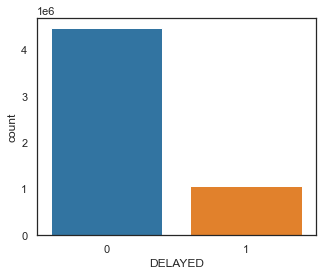

In [33]:
# Find the percentage of DELAYED Flights in the Train Dataset
print('TRAIN DATASET - DELAYED Count and Percentage')

idx_cnt  = df_train['DELAYED'].value_counts().sort_index().rename('COUNT')
tot_cnt  = len(df_train['DELAYED'])

rate_cnt = round(idx_cnt/tot_cnt*100,2).rename('PERCENTAGE')

display(pd.concat([idx_cnt,rate_cnt],axis=1))

plt.figure(figsize=(5,4))
sns.countplot(data=df_train,x='DELAYED',label="Count")

% 19.17 of the flights in the train dataset classified as DELAYED

TEST DATASET - DELAYED Count and Percentage


,COUNT,PERCENTAGE
0,790154,79.43
1,204586,20.57


<AxesSubplot:xlabel='DELAYED', ylabel='count'>

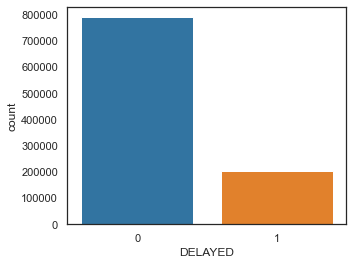

In [34]:
# Find the percentage of DELAYED Flights in the Test Dataset
print('TEST DATASET - DELAYED Count and Percentage')

idx_cnt  = df_test['DELAYED'].value_counts().sort_index().rename('COUNT')
tot_cnt  = len(df_test['DELAYED'])

rate_cnt = round(idx_cnt/tot_cnt*100,2).rename('PERCENTAGE')

display(pd.concat([idx_cnt,rate_cnt],axis=1))

plt.figure(figsize=(5,4))
sns.countplot(data=df_test,x='DELAYED',label="Count")

% 20.57 of the flights in the test dataset classified as DELAYED

# 3. Features

Things to note:
* 1. Data consists of 14 months, where 12 months (07.2018 - 06.2019) are for training/validation and 2 months (07.2019 - 08.2019) for testing purposes.
* 2. DepDelay (in minutes) is your target variable.
* 3. From an operational perspective, flight is classified as delayed, when it is late 15 minutes or more.
* 4. Scheduled departure time of the flight is the last available moment for doing prediction.
* 5. For modeling/analysis use a subset of 8 carriers, which are the most common in the dataset.
* 6. Feel free to use any publicly available information/dataset for feature engineering.
* 7. Don’t forget about exploratory data analysis (at least 3 questions & answers).


#1, #2, #3, and #5 notes have evaluated so far.

According to the #4, the last time for a flight is `CRS_DEP_TIME`, so I can't use the times which are `DEP_TIME`,`DEP_DELAY`,`CRS_ARR_TIME`, `ARR_TIME`, `ARR_DELAY`,`CRS_ELAPSED_TIME`and `ACTUAL_ELAPSED_TIME`.

In addition to that, as I've discussed before, I will exclude the cancelled flights. (`CANCELLED`and `CANCELLATION_CODE`).
Therefore, I will create a <b>'excluded_cols'</b> list and I will add these features.

And also, in the feature engineering part, if there are new columns that I want to exclude, I will add them to the <b>'excluded_cols'</b> list. This way, I can easily exclude these columns when I switch to the `Test` dataset.

In [35]:
# The columns that won't use in the modelling.
excluded_cols = ['CANCELLED','CANCELLATION_CODE',
                 'DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CRS_ARR_TIME','ARR_TIME','ARR_DELAY',
                 'CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME'
                  ]

#desired_features list contains desired features that I will use in the model section
desired_features = [] 

for i in list(df_train.columns):
    if i not in excluded_cols+['DELAYED']:
        desired_features.append(i)
desired_features.append('DELAYED')

## 3.1 Exploratory Data Analysis

In [36]:
# some basic statistics for numeric variables 
df_train[desired_features].describe()

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAYED
count,5.528595e+06,5.528595e+06,5.513455e+06,5.528595e+06,1.087253e+06,1.087253e+06,1.087253e+06,1.087253e+06,1.087253e+06,5.528595e+06
mean,2.418366e+03,1.328063e+03,1.138240e+02,8.215433e+02,2.010358e+01,3.868412e+00,1.605579e+01,1.075472e-01,2.629934e+01,1.916751e-01
std,1.641756e+03,4.911272e+02,7.072153e+01,5.956681e+02,6.202681e+01,3.192931e+01,3.548035e+01,4.003883e+00,5.066967e+01,3.936188e-01
min,1.000000e+00,1.000000e+00,4.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.134000e+03,9.100000e+02,6.100000e+01,3.770000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.098000e+03,1.320000e+03,9.500000e+01,6.510000e+02,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,3.558000e+03,1.735000e+03,1.440000e+02,1.065000e+03,1.700000e+01,0.000000e+00,2.000000e+01,0.000000e+00,3.200000e+01,0.000000e+00
max,7.439000e+03,2.359000e+03,6.690000e+02,4.983000e+03,2.592000e+03,2.692000e+03,1.498000e+03,1.078000e+03,2.014000e+03,1.000000e+00


In [37]:
# some basic statistics for object variables 
df_train[desired_features].describe(include="object")

,OP_UNIQUE_CARRIER,ORIGIN,DEST
count,5528595,5528595,5528595
unique,8,316,316
top,WN,ATL,ATL
freq,1328677,336715,336677


In [38]:
# checking how numeric variables change with the target
df_train[desired_features].groupby('DELAYED').mean().T

DELAYED,0,1
OP_CARRIER_FL_NUM,2428.028786,2377.614531
CRS_DEP_TIME,1284.333746,1512.478613
AIR_TIME,113.161580,116.624746
DISTANCE,815.677931,846.278670
CARRIER_DELAY,1.800117,25.337736
WEATHER_DELAY,0.194870,4.918919
NAS_DELAY,24.697113,13.584666
SECURITY_DELAY,0.013302,0.134498
LATE_AIRCRAFT_DELAY,1.066909,33.514941


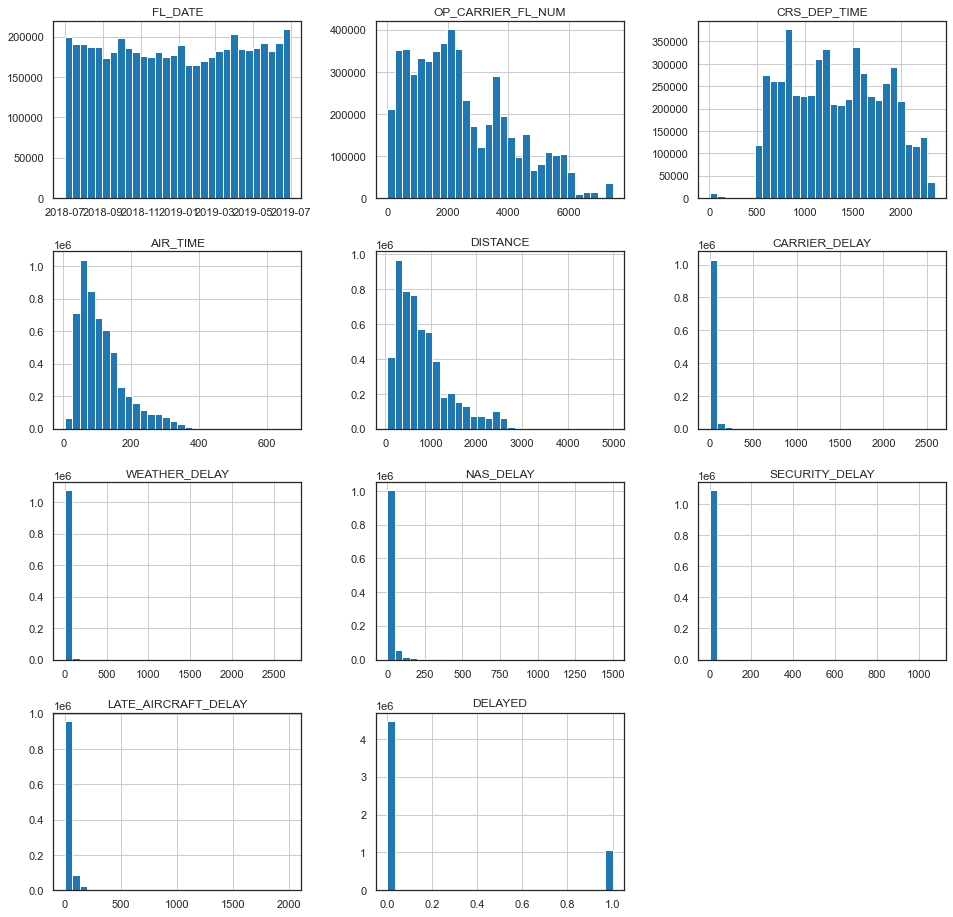

In [39]:
# distributions of attributes
df_train[desired_features].hist(figsize = [16,16],bins=30);

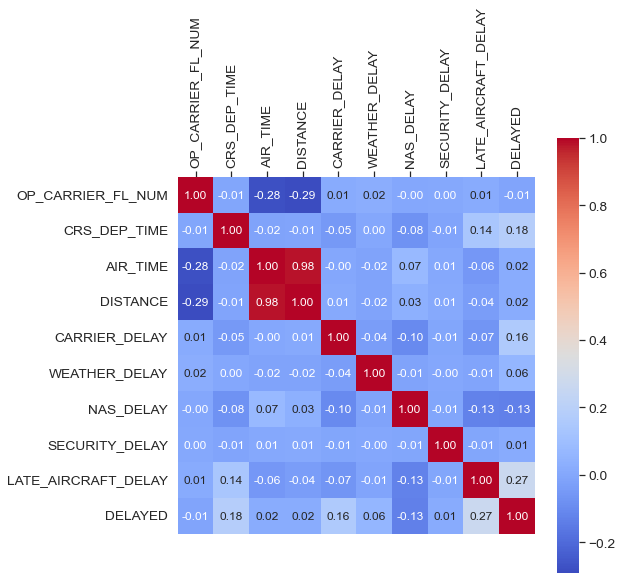

In [40]:
# Correlation table
sns.set(font_scale = 1.25)
correlation_matrix = df_train[desired_features].corr()
plt.figure(figsize=(8,8))
ax = sns.heatmap(correlation_matrix, vmax=1, cbar=True, square=True, annot=True, fmt='.2f', 
                 annot_kws={'size': 12}, cmap='coolwarm')
ax.xaxis.set_ticks_position('top')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

* `AIR_TIME` and `DISTANCE` highly correlated, we may select one of them. 
* Numeric variables are not seriously correlated with Target variable.

## 3.0 `FL_DATE` 

`FL_DATE`: Flight Date (yyyymmdd)

<AxesSubplot:>

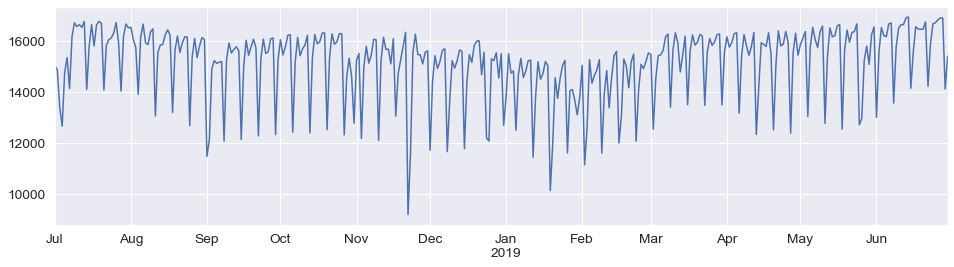

In [41]:
df_plot = df_train['FL_DATE'].value_counts().sort_index()

min_date = df_train['FL_DATE'].min()
max_date = df_train['FL_DATE'].max()

plt.figure(figsize=(16,4))
df_plot.plot()

<AxesSubplot:title={'center':'Daily Flights'}>

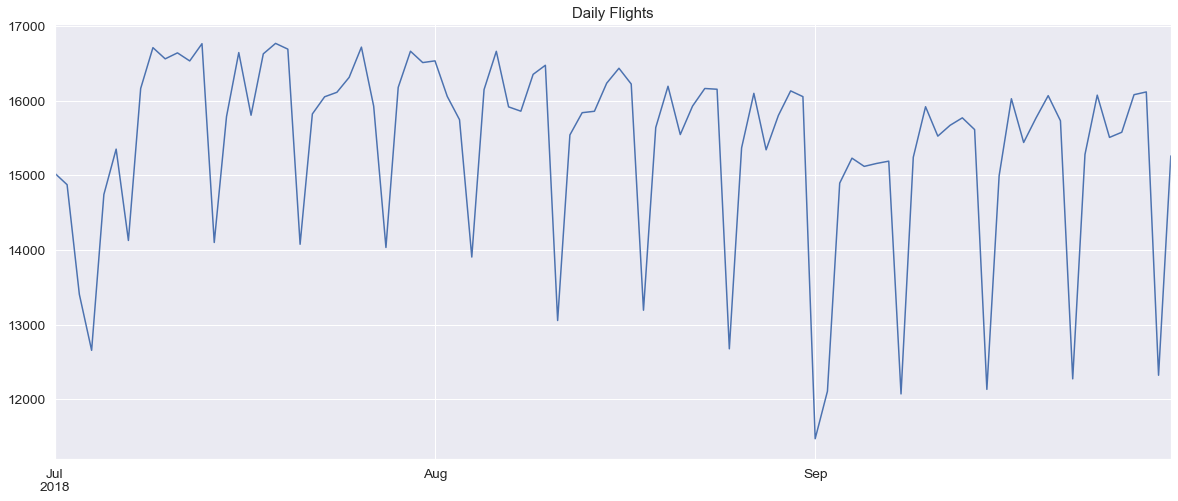

In [42]:
#Look Closer first 3 months
cnd = df_train['FL_DATE']<'2018-10-01'
df_plot = df_train.loc[cnd,'FL_DATE'].value_counts().sort_index()

plt.figure(figsize=(20,8))
df_plot.plot(title = 'Daily Flights')

It is obvious that there is a weekly periodicity for the data, they may affect the delay. Let's create a new feature and checked it. 

In [43]:
df_train['DAYOFWEEK'] = df_train['FL_DATE'].dt.dayofweek
df_train['MONTH'] = df_train['FL_DATE'].dt.month
df_train[['FL_DATE','DAYOFWEEK','MONTH']].sample(4)

,FL_DATE,DAYOFWEEK,MONTH
3908386,2019-01-13,6,1
6799273,2019-06-07,4,6
5574915,2019-04-08,0,4
1743121,2018-09-24,0,9


<b> Q. Which week days have lower/higher delayed flight rates? </b> 

In [44]:
a = pd.concat([
    pd.DataFrame(df_train.groupby('DAYOFWEEK')['DELAYED'].count()).rename(columns={'DELAYED':'COUNT'}),
    pd.DataFrame(df_train.groupby('DAYOFWEEK')['DELAYED'].sum())
],axis = 1
)
a['RATE'] = (a['DELAYED']/a['COUNT']*100).round(2)
a.sort_values(by='RATE')


,COUNT,DELAYED,RATE
DAYOFWEEK,,,
2,806794,140741,17.44
5,665692,117042,17.58
1,798754,141257,17.68
6,792661,152346,19.22
0,817996,161038,19.69
3,819722,171177,20.88
4,826976,176093,21.29


with respect to overall delayed rate(%19.17) in the training dataset;
* Wednesday, Saturday and Tuesday has lower DELAYED flight rates <br>
* Saturday and Monday have almost similar rate <br>
* Thursday and Friday has higher DELAYED flight rates <br>

<b> Q. Which Months have lower/higher delayed flight rates? </b> 

In [45]:
a = pd.concat([
    pd.DataFrame(df_train.groupby('MONTH')['DELAYED'].count()).rename(columns={'DELAYED':'COUNT'}),    
    pd.DataFrame(df_train.groupby('MONTH')['DELAYED'].sum()),
    pd.DataFrame(df_train.groupby('MONTH')['DELAYED'].count()).rank().rename(columns={'DELAYED':'COUNT_RANK(ASC)'}),
    pd.DataFrame(df_train.groupby('MONTH')['DELAYED'].sum()).rank().rename(columns={'DELAYED':'DELAYED_RANK(ASC)'}),
],axis = 1
)
a['RATE'] = (a['DELAYED']/a['COUNT']*100).round(2)
a.sort_values(by='RATE')

,COUNT,DELAYED,COUNT_RANK(ASC),DELAYED_RANK(ASC),RATE
MONTH,,,,,
9,445641,66100,3.0,1.0,14.83
10,473180,70860,7.0,2.0,14.98
3,477178,83946,8.0,6.0,17.59
1,436546,76949,2.0,3.0,17.63
11,447256,80255,4.0,4.0,17.94
12,452784,81601,5.0,5.0,18.02
4,462111,84472,6.0,7.0,18.28
5,483157,98698,10.0,9.0,20.43
2,399478,86571,1.0,8.0,21.67


* <b>Summer Flights, especially June and July, have the highest</b> DELAYED rate compared to other seasons
* <b>September and October has the far away lowest</b> DELAYED rate


In [46]:
# Add 'FL_DATE' into excluded_cols list
excluded_cols.append('FL_DATE')

## 3.1 `OP_UNIQUE_CARRIER` 

`OP_UNIQUE_CARRIER`: Unique Carrier Code

<b> Q. Which Carrier have lower/higher delayed flight rates? </b> 

In [47]:
a = pd.concat([
    pd.DataFrame(df_train.groupby('OP_UNIQUE_CARRIER')['DELAYED'].count()).rename(columns={'DELAYED':'COUNT'}),
    pd.DataFrame(df_train.groupby('OP_UNIQUE_CARRIER')['DELAYED'].sum())
],axis = 1
)
a['RATE'] = (a['DELAYED']/a['COUNT']*100).round(2)
a.sort_values(by='RATE')

,COUNT,DELAYED,RATE
OP_UNIQUE_CARRIER,,,
DL,964821,138501,14.36
YX,310451,51023,16.44
OO,788996,138738,17.58
MQ,300794,54726,18.19
UA,627100,121141,19.32
AA,912072,187294,20.54
WN,1328677,291874,21.97
B6,295684,76397,25.84


* <b>DL has best</b> rate whereas <b>B6 has the worst</b> rate in terms of target value

## 3.2 `OP_CARRIER_FL_NUM` 

`OP_CARRIER_FL_NUM`: Flight Number

In [48]:
df_check(df_train[['OP_CARRIER_FL_NUM']])

shape: (5528595, 1)


,column,dtypes,count,nunique,sum_null,null_ratio
0,OP_CARRIER_FL_NUM,int64,5528595,7064,0,0.0


In [49]:
df_train['OP_CARRIER_FL_NUM'].value_counts().describe()

count    7064.000000
mean      782.643686
std       555.704321
min         7.000000
25%       341.000000
50%       668.000000
75%      1219.000000
max      2707.000000
Name: OP_CARRIER_FL_NUM, dtype: float64

<AxesSubplot:xlabel='DELAYED', ylabel='OP_CARRIER_FL_NUM'>

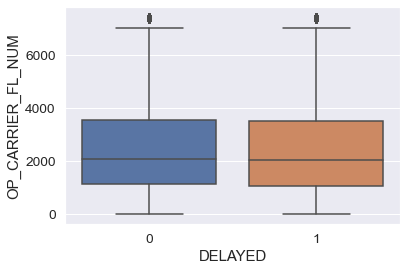

In [50]:
sns.boxplot(x=df_train['DELAYED'],y=df_train['OP_CARRIER_FL_NUM'])

In [51]:
df_train[['OP_CARRIER_FL_NUM','DELAYED']].corr()

,OP_CARRIER_FL_NUM,DELAYED
OP_CARRIER_FL_NUM,1.000000,-0.012087
DELAYED,-0.012087,1.000000


This feature seems irrevelant to target, I won't use it.

In [52]:
# Add 'OP_CARRIER_FL_NUM' into excluded_cols list
excluded_cols.append('OP_CARRIER_FL_NUM')

## 3.3 `ORIGIN`  & `DEST` 

`ORIGIN`: Origin Airport Code <br>
`DEST`: Destination Airport Code

In [53]:
pd.concat([
    df_check(df_train[['ORIGIN']]),
    df_check(df_train[['DEST']]),
]
)

shape: (5528595, 1)
shape: (5528595, 1)


,column,dtypes,count,nunique,sum_null,null_ratio
0,ORIGIN,object,5528595,316,0,0.0
0,DEST,object,5528595,316,0,0.0


The number of departure and arrival flights may affect on target. Since we have 316 airpots, I will convert encode them into rank with respect to lowest delayed rate rate to highest.

In [54]:
# Create the ranks for ORIGIN and DEST with respect to DELAYED mean
df_org_del_mean = pd.DataFrame(df_train.groupby('ORIGIN')['DELAYED'].mean().rank()).rename(columns={'DELAYED':'ORG_DEL_MEAN_RNK'})
df_des_del_mean = pd.DataFrame(df_train.groupby('DEST')['DELAYED'].mean().rank()).rename(columns={'DELAYED':'DES_DEL_MEAN_RNK'})

In [55]:
# Add the new feature called ORG_DEL_MEAN_RNK
df_train = pd.merge(df_train,
                    df_org_del_mean['ORG_DEL_MEAN_RNK'],
                    left_on='ORIGIN', 
                    right_index=True
                   )

# Add the new feature called DES_DEL_MEAN_RNK
df_train = pd.merge(df_train,
                    df_des_del_mean['DES_DEL_MEAN_RNK'],
                    left_on='DEST', 
                    right_index=True
                   )

As the number of flights increases, the delay may increase. Therefore, I will create a temporary column called TOTAL_FL.<br>

RANK_TOTAL_FL is the rank with respect to TOTAL_FL.

In [56]:
a = pd.concat([
        (df_train['ORIGIN'].value_counts()).rename('COUNT_ORIGIN'),
        #(df_train['ORIGIN'].value_counts().sort_index().rank(ascending=True)).rename('RANK_ORIGIN'),
        (df_train['DEST'].value_counts()).rename('COUNT_DEST'),
        #(df_train['DEST'].value_counts().sort_index().rank(ascending=True)).rename('RANK_DEST')
],axis=1
)
a['TOTAL_FL'] = a['COUNT_ORIGIN'] + a['COUNT_DEST']

b = pd.DataFrame(a['TOTAL_FL'].rank(ascending=True).rename('RANK_TOTAL_FL'))

c = pd.DataFrame(df_train.groupby('ORIGIN')['DELAYED'].mean())

df_rank_fl = pd.concat([a,b,c],axis=1)
df_rank_fl.head(5)

,COUNT_ORIGIN,COUNT_DEST,TOTAL_FL,RANK_TOTAL_FL,DELAYED
ATL,336715,336677,673392,316.0,0.177159
ORD,297740,297133,594873,315.0,0.224421
DFW,224730,224452,449182,314.0,0.233066
DEN,207982,207859,415841,313.0,0.202460
LAX,184270,184152,368422,312.0,0.189287


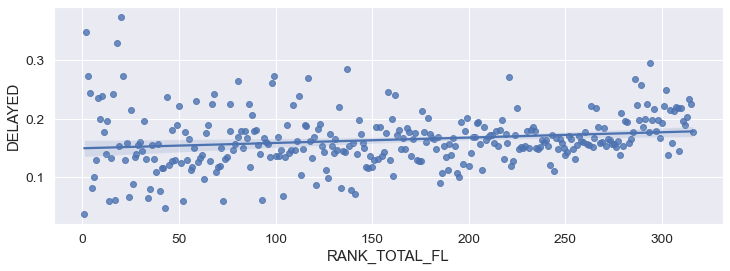

In [57]:
plt.figure(figsize=(12,4))
sns.regplot(data=df_rank_fl,x='RANK_TOTAL_FL', y='DELAYED');

There are slighly linearity between RANK_TOTAL_FL and the mean of the DELAYED.

It may have a small contribution to the model, but I keep it because RANK_TOTAL_FL represents the airport density.
Let's add this new feature to the train dataset.

In [58]:
# Add the new feature called RANK_TOTAL_FL
df_train = pd.merge(df_train,
                    df_rank_fl['RANK_TOTAL_FL'],
                    left_on='ORIGIN', 
                    right_index=True
                   )

Therefore, we don't need the 'ORIGIN' and 'DEST' anymore. 

In [59]:
# Add 'ORIGIN' and 'DEST' into excluded_cols list
excluded_cols.append('ORIGIN')
excluded_cols.append('DEST')

## 3.4 `CRS_DEP_TIME`

`CRS_DEP_TIME`: CRS Departure Time (local time: hhmm)<br>

CRS_DEP_TIME the only time that we can use in our model, let's check its relation between delay

In [60]:
df_check(df_train[['CRS_DEP_TIME']])

shape: (5528595, 1)


,column,dtypes,count,nunique,sum_null,null_ratio
0,CRS_DEP_TIME,int64,5528595,1344,0,0.0


<AxesSubplot:xlabel='DELAYED', ylabel='CRS_DEP_TIME'>

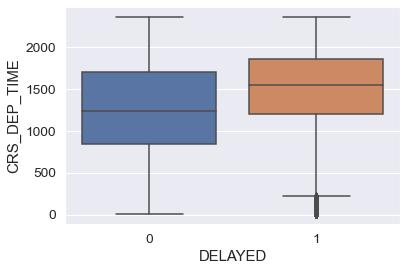

In [61]:
sns.boxplot(x=df_train['DELAYED'],y=df_train['CRS_DEP_TIME'])

Higher hours have higher delayed flights

<AxesSubplot:xlabel='CRS_DEP_TIME', ylabel='Count'>

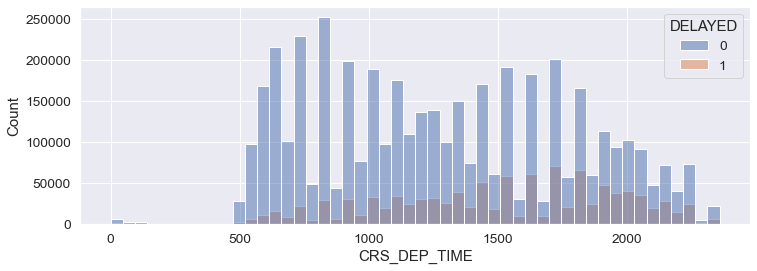

In [62]:
plt.figure(figsize=(12,4))
sns.histplot(df_train, x='CRS_DEP_TIME', bins=50, hue='DELAYED')

In [63]:
df_train['CRS_DEP_HOUR'] = (df_train['CRS_DEP_TIME']/100).apply(np.floor)

df_train[['CRS_DEP_TIME','CRS_DEP_HOUR']].sample(5)

,CRS_DEP_TIME,CRS_DEP_HOUR
3280825,1005,10.0
6599097,1026,10.0
1911741,1740,17.0
904981,1755,17.0
5878931,928,9.0


In [64]:
pd.concat([
    df_train.groupby('CRS_DEP_HOUR')['DELAYED'].count().rename('Count'),
    df_train.groupby('CRS_DEP_HOUR')['DELAYED'].mean().rename('Mean')
],axis=1
)

,Count,Mean
CRS_DEP_HOUR,,
0.0,10350,0.167536
1.0,3753,0.189448
2.0,1232,0.310065
3.0,1137,0.254178
4.0,642,0.174455
5.0,135517,0.061594
6.0,410755,0.065097
7.0,370671,0.087261
8.0,377956,0.106552


In [65]:
# Let's group the time of the Day
# 0 : Morning, 0 <= hour < 12
# 1 : Noon, 12 <= hour < 14
# 2 : Afternoon 15 <= hour <= 23

df_train['TIME_OF_DAY'] = df_train['CRS_DEP_HOUR'].apply(lambda x : 0 if x<12 else (1 if x<15 else 2))

In [66]:
pd.concat([
    df_train.groupby('TIME_OF_DAY')['DELAYED'].count().rename('Count'),
    df_train.groupby('TIME_OF_DAY')['DELAYED'].mean().rename('Mean')
],axis=1
)

,Count,Mean
TIME_OF_DAY,,
0,2314096,0.113563
1,972525,0.205528
2,2241974,0.266291


Although the sum of the number of flights in the morning and in the afternoon are almost equal to each other, their average delays are noticeably different.

In [67]:
df_train[['CRS_DEP_TIME','CRS_DEP_HOUR','TIME_OF_DAY']].corr()

,CRS_DEP_TIME,CRS_DEP_HOUR,TIME_OF_DAY
CRS_DEP_TIME,1.000000,0.999322,0.919201
CRS_DEP_HOUR,0.999322,1.000000,0.919698
TIME_OF_DAY,0.919201,0.919698,1.000000


I choose using TIME_OF_DAY instead of CRS_DEP_TIME and CRS_DEP_HOUR

In [68]:
# Add CRS_DEP_TIME and CRS_DEP_HOUR into excluded_cols list
excluded_cols.append('CRS_DEP_TIME')
excluded_cols.append('CRS_DEP_HOUR')

## 3.5 The Other Time Features

These time features are forbidden for our model, So I'm just taking a quick look.



`DEP_TIME`: Actual Departure Time (local time :  hhmm)<br>
`DEP_DELAY`: Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

`CRS_ARR_TIME`: CRS Arrival Time (local time :  hhmm) <br>
`ARR_TIME`: Actual Arrival Time (local time :  hhmm) <br>
`ARR_DELAY`: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.

`CRS_ELAPSED_TIME`: CRS Elapsed Time of Flight, in Minutes<br>
`ACTUAL_ELAPSED_TIME`: Elapsed Time of Flight, in Minutes<br>

In [69]:
pd.concat([
    df_check(df_train[['DEP_TIME']]),
    df_check(df_train[['DEP_DELAY']]),
    df_check(df_train[['CRS_ARR_TIME']]),
    df_check(df_train[['ARR_TIME']]),
    df_check(df_train[['ARR_DELAY']]),
    df_check(df_train[['CRS_ELAPSED_TIME']]),
    df_check(df_train[['ACTUAL_ELAPSED_TIME']]),
]
)

shape: (5528595, 1)
shape: (5528595, 1)
shape: (5528595, 1)
shape: (5528595, 1)
shape: (5528595, 1)
shape: (5528595, 1)
shape: (5528595, 1)


,column,dtypes,count,nunique,sum_null,null_ratio
0,DEP_TIME,float64,5528595,1440,0,0.0
0,DEP_DELAY,float64,5528595,1484,0,0.0
0,CRS_ARR_TIME,int64,5528595,1426,0,0.0
0,ARR_TIME,float64,5526457,1440,2138,0.0
0,ARR_DELAY,float64,5513455,1505,15140,0.3
0,CRS_ELAPSED_TIME,float64,5528595,559,0,0.0
0,ACTUAL_ELAPSED_TIME,float64,5513455,694,15140,0.3


In [70]:
df_train[['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME']].sample(5)

,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME
6859764,1730,1723.0,-7.0,2238,2225.0,-13.0,188.0,182.0
1348731,2025,2020.0,-5.0,50,46.0,-4.0,205.0,206.0
2080016,1428,1427.0,-1.0,1527,1527.0,0.0,59.0,60.0
5138259,2030,2050.0,20.0,2130,2144.0,14.0,60.0,54.0
5643430,1135,1126.0,-9.0,1248,1240.0,-8.0,133.0,134.0


## 3.6 `AIR_TIME` & `DISTANCE` 

`DISTANCE`: Distance between airports (miles)<br>
`AIR_TIME`: Flight Time, in Minutes


In [71]:
df_check(df_train[['DISTANCE','AIR_TIME']])

shape: (5528595, 2)


,column,dtypes,count,nunique,sum_null,null_ratio
0,DISTANCE,float64,5528595,1409,0,0.0
1,AIR_TIME,float64,5513455,650,15140,0.3


In [72]:
df_train[['DISTANCE','AIR_TIME']].describe()

,DISTANCE,AIR_TIME
count,5.528595e+06,5.513455e+06
mean,8.215433e+02,1.138240e+02
std,5.956681e+02,7.072153e+01
min,4.500000e+01,4.000000e+00
25%,3.770000e+02,6.100000e+01
50%,6.510000e+02,9.500000e+01
75%,1.065000e+03,1.440000e+02
max,4.983000e+03,6.690000e+02


<AxesSubplot:xlabel='DELAYED', ylabel='DISTANCE'>

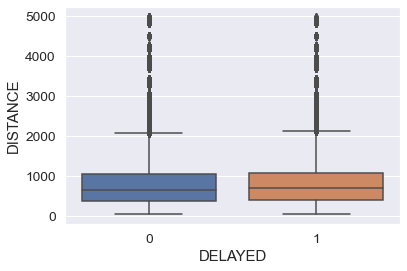

In [73]:
sns.boxplot(x=df_train['DELAYED'],y=df_train['DISTANCE'])

<AxesSubplot:xlabel='DELAYED', ylabel='AIR_TIME'>

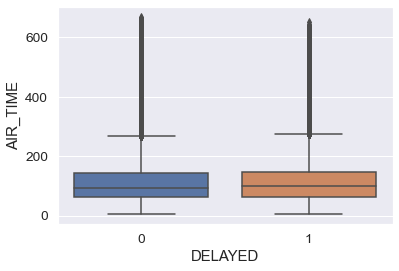

In [74]:
sns.boxplot(x=df_train['DELAYED'],y=df_train['AIR_TIME'])

<AxesSubplot:xlabel='AIR_TIME', ylabel='Count'>

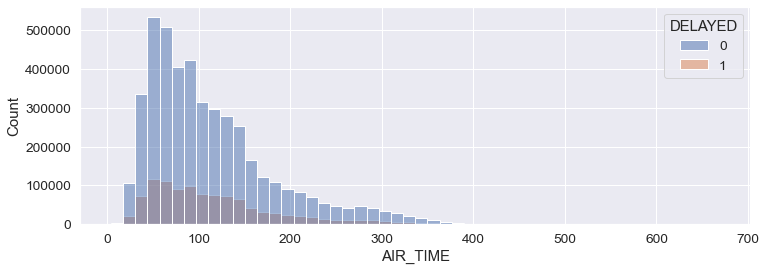

In [75]:
plt.figure(figsize=(12,4))
sns.histplot(df_train, x='AIR_TIME', bins=50, hue='DELAYED')

<b> Q. How is delayed flight rate affected by distance? </b> 

<AxesSubplot:xlabel='DISTANCE', ylabel='Count'>

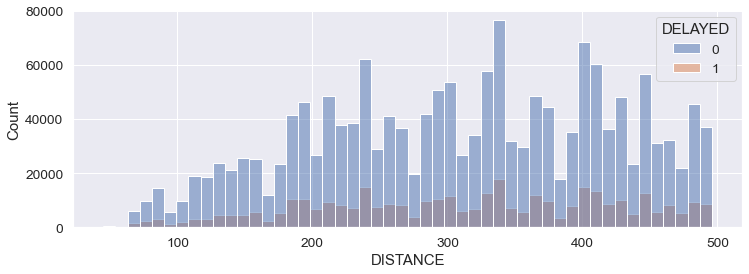

In [76]:
cnd = df_train['DISTANCE'] < 500

plt.figure(figsize=(12,4))
sns.histplot(df_train.loc[cnd], x='DISTANCE', bins=50, hue='DELAYED')

<AxesSubplot:xlabel='DISTANCE', ylabel='Count'>

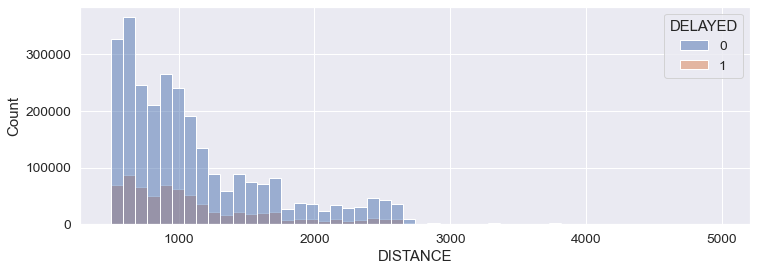

In [77]:
cnd = df_train['DISTANCE'] > 500

plt.figure(figsize=(12,4))
sns.histplot(df_train.loc[cnd], x='DISTANCE', bins=50, hue='DELAYED')

In [78]:
# Let's group the DISTANCE to answer the question
# 0 : Near, 0 <= hour < 12
# 1 : Middle, 12 <= hour < 14
# 2 : Far 15 <= hour <= 23

df_distance = df_train['DISTANCE'].apply(lambda x : 0 if x<175 else (1 if x<800 else 3))

df_distance = pd.concat(
                [
                    pd.DataFrame(df_distance).rename(columns={'DISTANCE':'DISTANCE_CAT'}),
                    df_train['DELAYED'],
                ],axis=1
            )
pd.concat([
    df_distance.groupby('DISTANCE_CAT')['DELAYED'].count().rename('Count'),
    df_distance.groupby('DISTANCE_CAT')['DELAYED'].mean().rename('Mean')
],axis=1
)

,Count,Mean
DISTANCE_CAT,,
0,236734,0.166237
1,3017166,0.185153
3,2274695,0.202974


The greater the distance, the greater the delay probability.

In [79]:
df_train[['DISTANCE','AIR_TIME','DELAYED']].corr()

,DISTANCE,AIR_TIME,DELAYED
DISTANCE,1.000000,0.982892,0.020221
AIR_TIME,0.982892,1.000000,0.019260
DELAYED,0.020221,0.019260,1.000000


DISTANCE and AIR_TIME highlt correlated (0.98) and AIR_TIME has some missing values, I won't use AIR_TIME my model.

In [80]:
# Add 'AIR_TIME' into excluded_cols list
excluded_cols.append('AIR_TIME')

## 3.7 DELAYS

`CARRIER_DELAY`: Carrier Delay, in Minutes<br>
`WEATHER_DELAY`: Weather Delay, in Minutes<br>
`NAS_DELAY`: National Air System Delay, in Minutes<br>
`SECURITY_DELAY`: Security Delay, in Minutes<br>
`LATE_AIRCRAFT_DELAY`: Late Aircraft Delay, in Minutes

In [81]:
pd.concat([
    df_check(df_train[['CARRIER_DELAY']]),
    df_check(df_train[['WEATHER_DELAY']]),
    df_check(df_train[['NAS_DELAY']]),
    df_check(df_train[['SECURITY_DELAY']]),
    df_check(df_train[['LATE_AIRCRAFT_DELAY']])
]
)

shape: (5528595, 1)
shape: (5528595, 1)
shape: (5528595, 1)
shape: (5528595, 1)
shape: (5528595, 1)


,column,dtypes,count,nunique,sum_null,null_ratio
0,CARRIER_DELAY,float64,1087253,1332,4441342,80.3
0,WEATHER_DELAY,float64,1087253,1012,4441342,80.3
0,NAS_DELAY,float64,1087253,808,4441342,80.3
0,SECURITY_DELAY,float64,1087253,239,4441342,80.3
0,LATE_AIRCRAFT_DELAY,float64,1087253,936,4441342,80.3


In [82]:
cols = ['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
cnd = ~(df_train['CARRIER_DELAY'].isna())

df_train.loc[cnd,cols].sample(5)

,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
6992923,2.0,0.0,10.0,0.0,92.0
1064784,0.0,0.0,25.0,0.0,0.0
3594814,13.0,0.0,8.0,0.0,31.0
5964462,30.0,0.0,0.0,0.0,0.0
7003642,0.0,27.0,0.0,0.0,0.0


In [83]:
cnd1 = df_train['DELAYED'] == 0 
cnd2 = ~(df_train['CARRIER_DELAY'].isna())

df_train.loc[(cnd1 & cnd2),['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']].sample(5)

,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
1080745,1.0,0.0,9.0,0.0,11.0
610252,9.0,0.0,9.0,0.0,0.0
6614832,9.0,0.0,14.0,0.0,0.0
4068608,2.0,0.0,10.0,0.0,6.0
2940911,0.0,0.0,16.0,0.0,0.0


In [84]:
cnd1 = df_train['DELAYED']==1
cnd2 = ~(df_train['CARRIER_DELAY'].isna())

df_train.loc[(cnd1 & cnd2),['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']].sample(5)

,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
5546224,0.0,0.0,70.0,0.0,0.0
1059130,0.0,0.0,54.0,0.0,0.0
772670,0.0,230.0,21.0,0.0,64.0
4809013,0.0,0.0,25.0,0.0,0.0
7101488,57.0,24.0,0.0,0.0,0.0


In [85]:
df_train[cols].describe()

,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,1.087253e+06,1.087253e+06,1.087253e+06,1.087253e+06,1.087253e+06
mean,2.010358e+01,3.868412e+00,1.605579e+01,1.075472e-01,2.629934e+01
std,6.202681e+01,3.192931e+01,3.548035e+01,4.003883e+00,5.066967e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,4.000000e+00
75%,1.700000e+01,0.000000e+00,2.000000e+01,0.000000e+00,3.200000e+01
max,2.592000e+03,2.692000e+03,1.498000e+03,1.078000e+03,2.014000e+03


In [86]:
df_train[cols+['DELAYED']].groupby('DELAYED').describe().T

DELAYED                                0              1
CARRIER_DELAY       count  241777.000000  845476.000000
                    mean        1.800117      25.337736
                    std         3.728091      69.428779
                    min         0.000000       0.000000
                    25%         0.000000       0.000000
                    50%         0.000000       4.000000
                    75%         0.000000      24.000000
                    max        14.000000    2592.000000
WEATHER_DELAY       count  241777.000000  845476.000000
                    mean        0.194870       4.918919
                    std         1.372383      36.131925
                    min         0.000000       0.000000
                    25%         0.000000       0.000000
                    50%         0.000000       0.000000
                    75%         0.000000       0.000000
                    max       100.000000    2692.000000
NAS_DELAY           count  241777.000000  845476.000000
                    mean       24.697113      13.584666
                    std        17.043220      38.837096
                    min         0.000000       0.000000
                    25%        15.000000       0.000000
                    50%        20.000000       0.000000
                    75%        29.000000      10.000000
                    max       313.000000    1498.000000
SECURITY_DELAY      count  241777.000000  845476.000000
                    mean        0.013302       0.134498
                    std         0.356601       4.536054
                    min         0.000000       0.000000
                    25%         0.000000       0.000000
                    50%         0.000000       0.000000
                    75%         0.000000       0.000000
                    max        14.000000    1078.000000
LATE_AIRCRAFT_DELAY count  241777.000000  845476.000000
                    mean        1.066909      33.514941
                    std         2.999348      55.361576
                    min         0.000000       0.000000
                    25%         0.000000       0.000000
                    50%         0.000000      16.000000
                    75%         0.000000      43.000000
                    max        74.000000    2014.000000

Although we have these features in 20% of our data, these features seem to make a serious difference for delayed and on time flights.

`CARRIER_DELAY`,`WEATHER_DELAY` and `LATE_AIRCRAFT_DELAY` are high values for delayed flights, while `LATE_AIRCRAFT_DELAY` is high values for on-time flights.

In [87]:
# Since these delays has too many outliers, I will create 3 values for them.
# If the FLG value is 
#     2 : equal or greater than 15 (our delay threshold)
#     1 : between 1 and 14 
#     0 : otherwise

cols = ['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
cols2 = cols.copy()
for c in cols:
    new_c_name = c+'_FLG'
    cols2.append(new_c_name)
    df_train[new_c_name] = df_train[c].apply(lambda x: 2 if x>=15 else(1 if x>0 else 0))
    #df_train.loc[df_train[c]>1,new_c_name] = 1

In [88]:
#Sample view for existing and new features 
cnd = ~(df_train['CARRIER_DELAY'].isna())
df_train.loc[cnd,cols2].sample(5)

,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CARRIER_DELAY_FLG,WEATHER_DELAY_FLG,NAS_DELAY_FLG,SECURITY_DELAY_FLG,LATE_AIRCRAFT_DELAY_FLG
5298977,82.0,0.0,0.0,0.0,0.0,2,0,0,0,0
7195184,19.0,0.0,0.0,0.0,9.0,2,0,0,0,1
5108005,0.0,0.0,0.0,0.0,16.0,0,0,0,0,2
1208836,0.0,0.0,0.0,0.0,35.0,0,0,0,0,2
2543934,112.0,0.0,2.0,0.0,0.0,2,0,1,0,0


In [89]:
# Add old features to the [excluded_cols]
cols = ['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
for i in cols: 
    excluded_cols.append(i)

# 4. Setting the Train Dataset

In [90]:
# I've updated excluded list so far, now update the desired_features

desired_features = [] 
for i in list(df_train.columns):
    if i not in excluded_cols+['DELAYED']:
        desired_features.append(i)
desired_features.append('DELAYED')

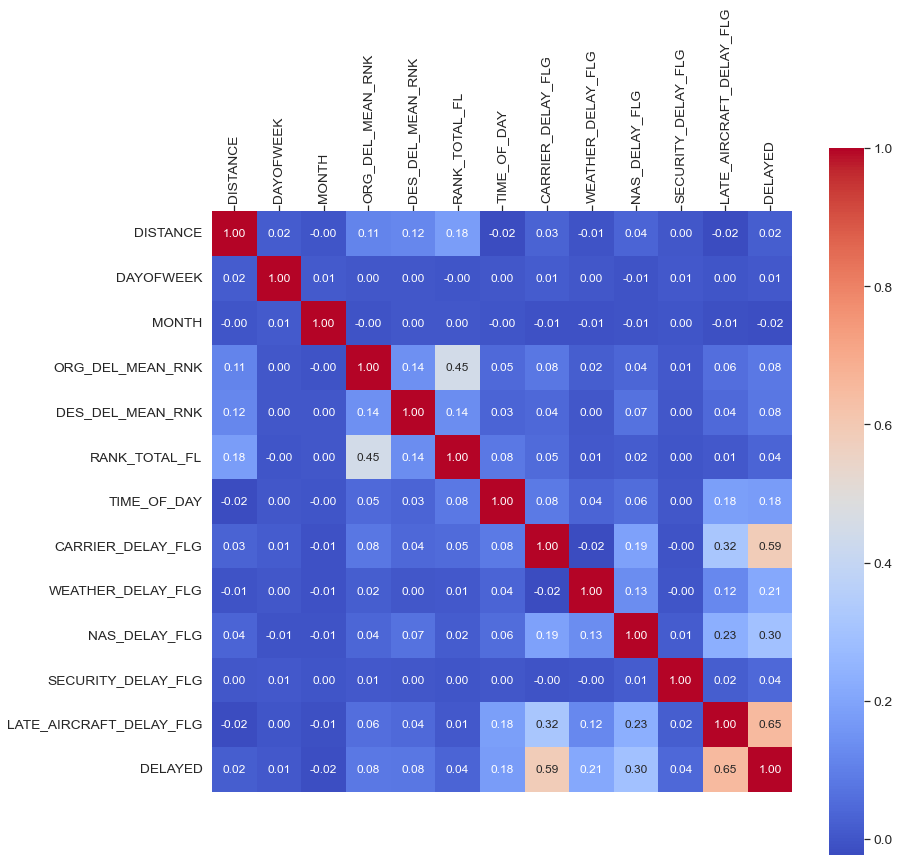

In [91]:
# Correlation table
sns.set(font_scale = 1.25)
correlation_matrix = df_train[desired_features].corr()
plt.figure(figsize=(13,13))
ax = sns.heatmap(correlation_matrix, vmax=1, cbar=True, square=True, annot=True, fmt='.2f', 
                 annot_kws={'size': 12}, cmap='coolwarm')
ax.xaxis.set_ticks_position('top')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

* After transforming the features, some features correlation with the target has increased

## 4.1 Apply Created Features for the Test Dataset

In [92]:
############## APPLY CREATED FEATURES FOR THE TEST DATA ##########

df_test['DAYOFWEEK'] = df_test['FL_DATE'].dt.dayofweek
df_test['MONTH'] = df_test['FL_DATE'].dt.month

# Add the new feature called ORG_DEL_MEAN_RNK
df_test = pd.merge(df_test,
                    df_org_del_mean['ORG_DEL_MEAN_RNK'],
                    left_on='DEST', 
                    right_index=True
                   )

# Add the new feature called DES_DEL_MEAN_RNK
df_test = pd.merge(df_test,
                    df_des_del_mean['DES_DEL_MEAN_RNK'],
                    left_on='DEST', 
                    right_index=True
                   )

# Add the new feature called RANK_TOTAL_FL
df_test = pd.merge(df_test,
                    df_rank_fl['RANK_TOTAL_FL'],
                    left_on='ORIGIN', 
                    right_index=True
                   )

df_test['CRS_DEP_HOUR'] = (df_test['CRS_DEP_TIME']/100).apply(np.floor)

df_test['TIME_OF_DAY'] = df_test['CRS_DEP_HOUR'].apply(lambda x : 0 if x<12 else (1 if x<15 else 2))

cols = ['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
for c in cols:
    new_c_name = c+'_FLG'
    df_test[new_c_name] = df_test[c].apply(lambda x: 2 if x>=15 else(1 if x>0 else 0))

###############################################################

In [93]:
print(f'df_train.shape:\t{df_train.shape}\ndf_test.shape:\t{df_test.shape}')

df_train.shape:	(5528595, 35)
df_test.shape:	(994677, 35)


# 5. Models

XGBoost, LightGBM, Logistic Regression and Random Forest models will be conducted. 

Since the data was grouped as train and test from the beginning (according to the given directive), cross validation was not applied.

In [94]:
## Set Train Test Datasets

X_train = df_train[desired_features].drop(columns=['DELAYED'])
y_train = df_train['DELAYED']

X_test = df_test[desired_features].drop(columns=['DELAYED'])
y_test = df_test['DELAYED']


print(f'X_train: {X_train.shape}\t, y_train: {y_train.shape}')
print(f'X_test:  {X_test.shape}\t, y_test:  {y_test.shape}')

X_train: (5528595, 13)	, y_train: (5528595,)
X_test:  (994677, 13)	, y_test:  (994677,)


In [95]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5528595 entries, 137 to 7296158
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   OP_UNIQUE_CARRIER        object 
 1   DISTANCE                 float64
 2   DAYOFWEEK                int64  
 3   MONTH                    int64  
 4   ORG_DEL_MEAN_RNK         float64
 5   DES_DEL_MEAN_RNK         float64
 6   RANK_TOTAL_FL            float64
 7   TIME_OF_DAY              int64  
 8   CARRIER_DELAY_FLG        int64  
 9   WEATHER_DELAY_FLG        int64  
 10  NAS_DELAY_FLG            int64  
 11  SECURITY_DELAY_FLG       int64  
 12  LATE_AIRCRAFT_DELAY_FLG  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 719.5+ MB


In [96]:
X_train.select_dtypes(exclude=['object']).columns

Index(['DISTANCE', 'DAYOFWEEK', 'MONTH', 'ORG_DEL_MEAN_RNK',
       'DES_DEL_MEAN_RNK', 'RANK_TOTAL_FL', 'TIME_OF_DAY', 'CARRIER_DELAY_FLG',
       'WEATHER_DELAY_FLG', 'NAS_DELAY_FLG', 'SECURITY_DELAY_FLG',
       'LATE_AIRCRAFT_DELAY_FLG'],
      dtype='object')

In [97]:
X_train.select_dtypes(include=['object','category']).columns

Index(['OP_UNIQUE_CARRIER'], dtype='object')

In [98]:
pipe_num = Pipeline([
                     ("scaler", pre.StandardScaler())
])

pipe_cat = Pipeline([
                     ("onehot", pre.OneHotEncoder(handle_unknown="ignore"))
])

ct = ColumnTransformer([
                      ("num", pipe_num, X_train.select_dtypes(exclude=['object','category']).columns), # numeric
                      ("cat", pipe_cat, X_train.select_dtypes(include=['object','category']).columns) # categoric
])

## 5.1 XGBoost

In [99]:
# 'XGBoost'
pipe_final = Pipeline([
                       ("ct", ct),
                       ("scaler", pre.StandardScaler()),
                       ("xgb", XGBClassifier( seed = 28))
])

pipe_final.fit(X_train, y_train)
#Skip the CV part
#print(round(mdl.cross_val_score(pipe_final, X_train, y_train, cv=5).mean(),2))

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['DISTANCE', 'DAYOFWEEK', 'MONTH', 'ORG_DEL_MEAN_RNK',
       'DES_DEL_MEAN_RNK', 'RANK_TOTAL_FL', 'TIME_OF_DAY', 'CARRIER_DELAY_FLG',
       'WEATHER_DELAY_FLG', 'NAS_DELAY_FLG', 'SECURITY_DELAY_FLG',
       'LATE_AIRCRAFT_DELAY_FLG'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=28, reg_alpha=0,
                               reg_lambda=1, ...))])

In [100]:
# get  predictions
y_pred = pipe_final.predict(X_test)
print("roc_auc_score:", round(met.roc_auc_score(y_test, y_pred),4))
print()
print(met.classification_report(y_test, y_pred,digits=4))


roc_auc_score: 0.8763

              precision    recall  f1-score   support

           0     0.9408    0.9943    0.9668    790101
           1     0.9717    0.7583    0.8518    204576

    accuracy                         0.9457    994677
   macro avg     0.9563    0.8763    0.9093    994677
weighted avg     0.9471    0.9457    0.9431    994677



## 5.2 LGBM

In [101]:
#model_name = 'LGBM'

pipe_final = Pipeline([
                       ("ct", ct),
                       ("scaler", pre.StandardScaler()),
                       ("lgbm", LGBMClassifier(random_state = 28))
])

pipe_final.fit(X_train, y_train)
#Skip the CV part
#print(round(mdl.cross_val_score(pipe_final, X_train, y_train, cv=5).mean(),2))

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['DISTANCE', 'DAYOFWEEK', 'MONTH', 'ORG_DEL_MEAN_RNK',
       'DES_DEL_MEAN_RNK', 'RANK_TOTAL_FL', 'TIME_OF_DAY', 'CARRIER_DELAY_FLG',
       'WEATHER_DELAY_FLG', 'NAS_DELAY_FLG', 'SECURITY_DELAY_FLG',
       'LATE_AIRCRAFT_DELAY_FLG'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['OP_UNIQUE_CARRIER'], dtype='object'))])),
                ('scaler', StandardScaler()),
                ('lgbm', LGBMClassifier(random_state=28))])

In [102]:
# get  predictions
y_pred = pipe_final.predict(X_test)
print("roc_auc_score:", round(met.roc_auc_score(y_test, y_pred),4))
print()
print(met.classification_report(y_test, y_pred,digits=4))


roc_auc_score: 0.8761

              precision    recall  f1-score   support

           0     0.9407    0.9944    0.9668    790101
           1     0.9723    0.7578    0.8518    204576

    accuracy                         0.9458    994677
   macro avg     0.9565    0.8761    0.9093    994677
weighted avg     0.9472    0.9458    0.9431    994677



## 5.3 Random Forrest

In [103]:
# 'RandomForrest'

pipe_final = Pipeline([
                       ("ct", ct),
                       ("scaler", pre.StandardScaler()),
                       ("lr", RandomForestClassifier(random_state = 28))
])

pipe_final.fit(X_train, y_train)
#Skip the CV part
#print(round(mdl.cross_val_score(pipe_final, X_train, y_train, cv=5).mean(),2))

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['DISTANCE', 'DAYOFWEEK', 'MONTH', 'ORG_DEL_MEAN_RNK',
       'DES_DEL_MEAN_RNK', 'RANK_TOTAL_FL', 'TIME_OF_DAY', 'CARRIER_DELAY_FLG',
       'WEATHER_DELAY_FLG', 'NAS_DELAY_FLG', 'SECURITY_DELAY_FLG',
       'LATE_AIRCRAFT_DELAY_FLG'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['OP_UNIQUE_CARRIER'], dtype='object'))])),
                ('scaler', StandardScaler()),
                ('lr', RandomForestClassifier(random_state=28))])

In [104]:
# get  predictions

y_pred = pipe_final.predict(X_test)
print("roc_auc_score:", round(met.roc_auc_score(y_test, y_pred),4))
print()
print(met.classification_report(y_test, y_pred,digits=4))

roc_auc_score: 0.8746

              precision    recall  f1-score   support

           0     0.9400    0.9943    0.9664    790101
           1     0.9716    0.7550    0.8497    204576

    accuracy                         0.9451    994677
   macro avg     0.9558    0.8746    0.9081    994677
weighted avg     0.9465    0.9451    0.9424    994677



## 5.4 Logistic Regression

In [105]:
# 'LogisticRegression'

pipe_final = Pipeline([
                       ("ct", ct),
                       ("scaler", pre.StandardScaler()),
                       ("lr", lin.LogisticRegression(random_state = 28))
])

pipe_final.fit(X_train, y_train)
#Skip the CV part
#print(round(mdl.cross_val_score(pipe_final, X_train, y_train, cv=5).mean(),2))

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['DISTANCE', 'DAYOFWEEK', 'MONTH', 'ORG_DEL_MEAN_RNK',
       'DES_DEL_MEAN_RNK', 'RANK_TOTAL_FL', 'TIME_OF_DAY', 'CARRIER_DELAY_FLG',
       'WEATHER_DELAY_FLG', 'NAS_DELAY_FLG', 'SECURITY_DELAY_FLG',
       'LATE_AIRCRAFT_DELAY_FLG'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['OP_UNIQUE_CARRIER'], dtype='object'))])),
                ('scaler', StandardScaler()),
                ('lr', LogisticRegression(random_state=28))])

In [106]:
# get  predictions

y_pred = pipe_final.predict(X_test)
print("roc_auc_score:", round(met.roc_auc_score(y_test, y_pred),4))
print()
print(met.classification_report(y_test, y_pred,digits=4))


roc_auc_score: 0.864

              precision    recall  f1-score   support

           0     0.9366    0.9858    0.9606    790101
           1     0.9312    0.7422    0.8260    204576

    accuracy                         0.9357    994677
   macro avg     0.9339    0.8640    0.8933    994677
weighted avg     0.9355    0.9357    0.9329    994677



## 5.5 Compare Models

In [107]:
# evaluation results

d = {'Model': ["XGBoost", "LGBM", "Random Forrest", "Logistic Regression"], 
'AUC':      [0.8763,0.8761,0.8746,0.864],
'Accuracy': [0.9457,0.9458,0.9451,0.9357], 
'Precision':[0.9717,0.9723,0.9716,0.9312],
'Recall':   [0.7583,0.7578,0.7550,0.7422],
'f1-score': [0.8518,0.8518,0.8497,0.8260]
}
eval_result = pd.DataFrame(data=d)
eval_result

,Model,AUC,Accuracy,Precision,Recall,f1-score
0,XGBoost,0.8763,0.9457,0.9717,0.7583,0.8518
1,LGBM,0.8761,0.9458,0.9723,0.7578,0.8518
2,Random Forrest,0.8746,0.9451,0.9716,0.7550,0.8497
3,Logistic Regression,0.8640,0.9357,0.9312,0.7422,0.8260


Actually all models have good results but XGBoost and LGBM have best scores. 

O ut of these two, I select LGBM because it has slightly better performance on Precision.Also, LGBM is much faster, since our dataset is large, speed can also be considered as an important criterion.

## 5.6 Fine Tuning

My aim was to search for better parameters, but since parameter tuning takes too long, I stopped it manually. So, I skip this part.

In [110]:
# # Fine Tuning

# pipe_final = Pipeline([
                       # ("ct", ct),
                       # ("scaler", pre.StandardScaler()),
                       # ("lgbm", LGBMClassifier(random_state = 28))
# ])


# params = [{
    # 'lgbm__colsample_bytree': [0.7, 0.8],
    # 'lgbm__max_depth'       : [4],
    # 'lgbm__num_leaves'      : [10, 20],
    # 'lgbm__reg_alpha'       : [1.1, 1.2],
    # 'lgbm__reg_lambda'      : [1.1, 1.2],
    # 'lgbm__min_split_gain'  : [0.3, 0.4],
    # 'lgbm__subsample'       : [0.8, 0.9],
    # 'lgbm__subsample_freq'  : [10, 20]
           # }]


# grid_search = GridSearchCV(pipe_final, param_grid = params,scoring = 'recall', cv = 2,verbose = 1, n_jobs = -1)
# grid_search.fit(X_train, y_train)

# # see best params
# print(grid_search.best_params_)

# print("Model: LGBM. Performance on test")
# y_pred_test = grid_search.best_estimator_.predict(X_test)
# print(met.classification_report(y_test, y_pred_test,digits=4))